In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/archive/english.csv")
df

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0
...,...,...
3405,Img/img062-051.png,z
3406,Img/img062-052.png,z
3407,Img/img062-053.png,z
3408,Img/img062-054.png,z


In [ ]:
def read_local_image(x, base_path="/content/drive/MyDrive/archive/"):
    # Combine the base path with the relative path
    image_path = os.path.join(base_path, x)

    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    return image

def read_url_pic(x):
    base_url = "/content/drive/MyDrive/archive/"

    # Combine the base URL with the relative path
    image_url = base_url + x

    with urllib.request.urlopen(image_url) as url:
        s = url.read()

    arr = np.asarray(bytearray(s), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    return image

def preprocess_dataset(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        image_path = row['image']
        label = row['label']

        # Read and resize the image
        img = read_local_image("/content/drive/MyDrive/archive/"+image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (64, 64))

        images.append(img)
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [ ]:
# Preprocess the dataset
images, labels = preprocess_dataset(df)
print(images)
print(labels)

[[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 ...

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 2

In [ ]:
# Perform one-hot encoding on labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_labels = onehot_encoder.fit_transform(integer_encoded)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onehot_labels, test_size=0.2, random_state=42)


In [ ]:
# Flatten the images to 1D arrays
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)


In [ ]:
# Neural Network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.zeros((1, self.output_size))

        # Lists to store loss and accuracy for visualization
        self.loss_history = []

    def sigmoid(self, x):
      x = np.clip(x, -500, 500)
      return 1 / (1 + np.exp(-x))

    def sigmoid_prime(self, x):
        return x * (1 - x)

    def forward(self, X):
        self.z = np.dot(X, self.W1) + self.b1
        self.z2 = self.sigmoid(self.z)
        self.z3 = np.dot(self.z2, self.W2) + self.b2
        o = self.sigmoid(self.z3)
        return o

    def backward(self, X, y, o, learning_rate=0.01):
        self.o_error = y - o
        self.o_delta = self.o_error * self.sigmoid_prime(o)
        self.z2_error = np.dot(self.o_delta, self.W2.T)
        self.z2_delta = self.z2_error * self.sigmoid_prime(self.z2)

        # Update weights and biases
        self.W1 += learning_rate * np.dot(X.T, self.z2_delta)
        self.b1 += learning_rate * np.sum(self.z2_delta, axis=0, keepdims=True)
        self.W2 += learning_rate * np.dot(self.z2.T, self.o_delta)
        self.b2 += learning_rate * np.sum(self.o_delta, axis=0, keepdims=True)

    def train(self, X, y, epochs=100, learning_rate=0.01):
        for epoch in range(epochs):
            o = self.forward(X)
            self.backward(X, y, o, learning_rate)

            # Calculate and store the loss
            loss = np.mean(np.abs(self.o_error))
            self.loss_history.append(loss)

            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')

    def predict(self, X):
        return np.round(self.forward(X))

In [ ]:
# Create and train the neural network
input_size = X_train_flatten.shape[1]
hidden_size = 128
output_size = 62
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the model
nn.train(X_train_flatten, y_train, epochs=50, learning_rate=0.01)

Epoch 10/50, Loss: 0.0787
Epoch 20/50, Loss: 0.0788
Epoch 30/50, Loss: 0.0788
Epoch 40/50, Loss: 0.0789
Epoch 50/50, Loss: 0.0789


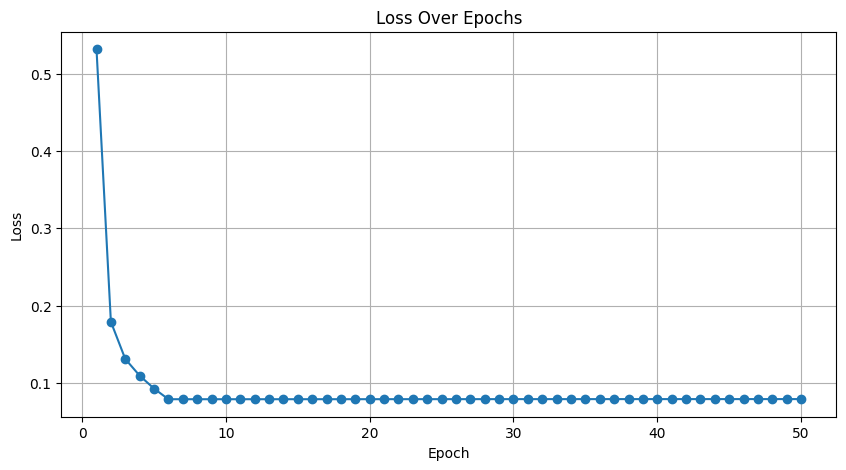

In [ ]:
# Plot loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), nn.loss_history, marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

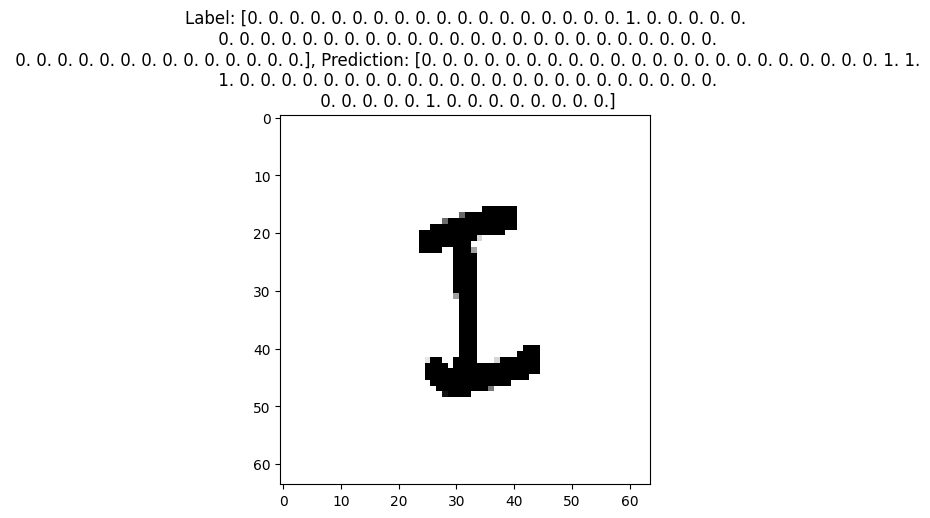

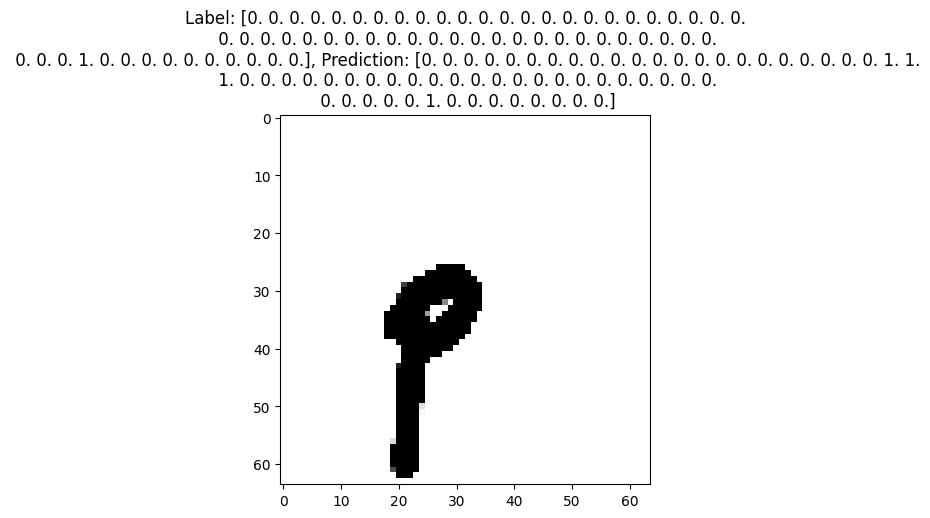

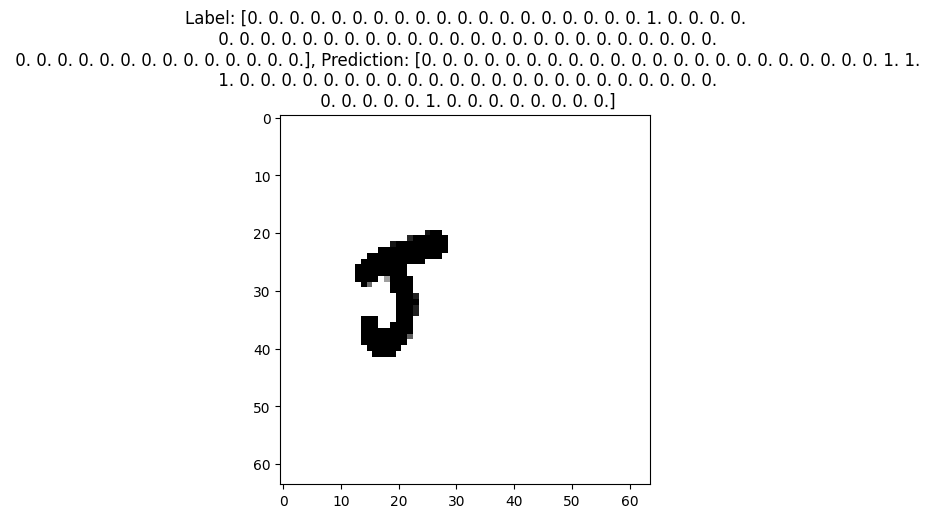

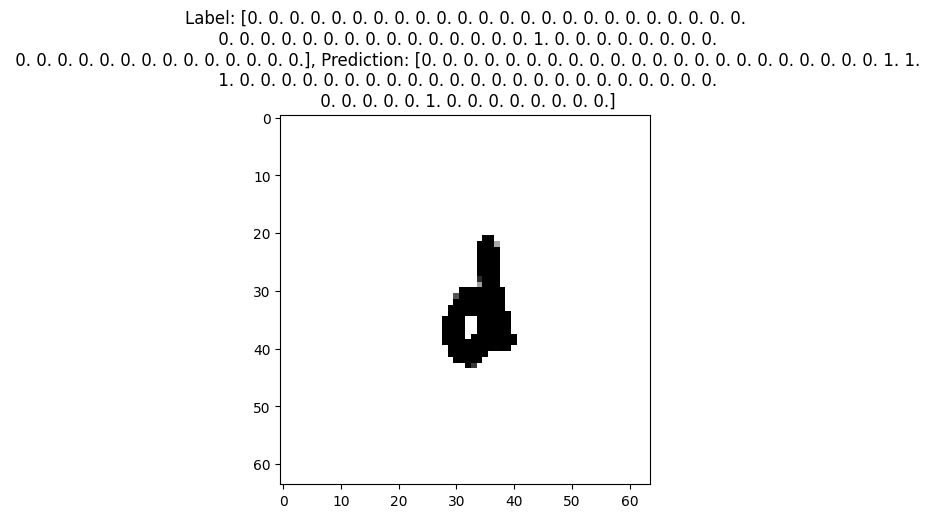

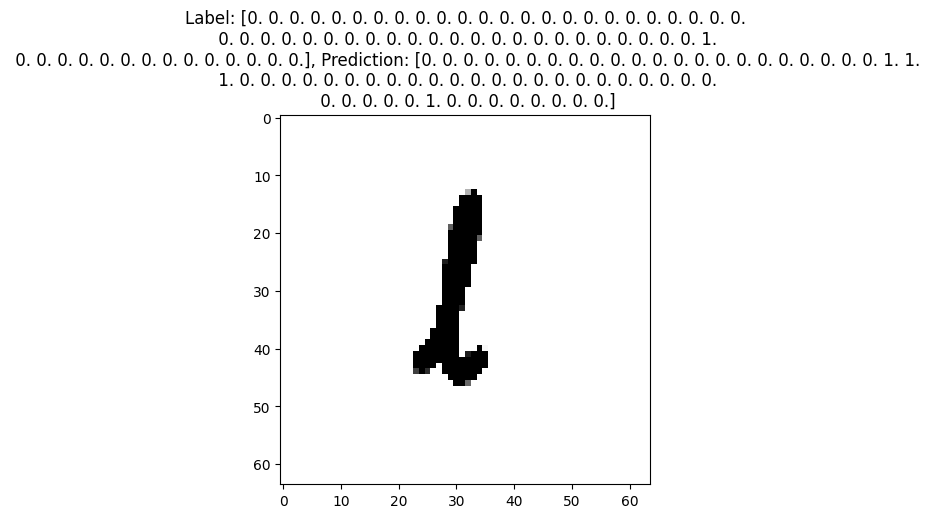

In [ ]:
# Visualize some predictions from the test set
num_samples_to_visualize = 5
sample_indices = np.random.choice(len(X_test_flatten), num_samples_to_visualize, replace=False)
for index in sample_indices:
    input_sample = X_test_flatten[index]
    label = y_test[index]
    prediction = nn.predict(input_sample.reshape(1, -1))[0]

    # Reshape the flattened input for visualization
    input_sample_reshaped = input_sample.reshape(64, 64)

    plt.figure()
    plt.imshow(input_sample_reshaped, cmap='gray')
    plt.title(f'Label: {label}, Prediction: {prediction}')
    plt.show()


In [ ]:
# Evaluate the accuracy on the test set
def calculate_accuracy(predictions, true_labels):
    correct_predictions = np.sum(predictions == true_labels)
    total_samples = len(true_labels)
    accuracy = correct_predictions / total_samples
    return accuracy

# Make predictions on the test set
predictions = nn.predict(X_test_flatten)

# Convert one-hot encoded predictions and true labels back to integers
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Calculate and print the accuracy
accuracy = calculate_accuracy(predicted_labels, true_labels)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


Accuracy on the test set: 1.32%
